In [1]:
import pickle,os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# set random seed
np.random.seed(42)

### Model Training

In [ ]:
"""
except HR, TEMP, datetime and label drop other columns and also there is couple of records for the same second keep one record and drop other records as well.
"""

'\nexcept HR, TEMP, datetime and label drop other columns and also there is couple of records for the same second keep one record and drop other records as well.\nfrom the id in this dataset indicate the participants. using datetime column get a same time range like 15 min of data from each participant\n\nlabel = stress scale which rate from 0 to 2\n'

In [3]:
def load_data_stress(data_path = "data/stress_data.csv"):
        df = pd.read_csv(data_path)
        df = df[['HR', 'TEMP', 'datetime', 'label', 'id']]
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.groupby(['id', 'datetime']).first().reset_index()
        df = df.sort_values(by = ['id', 'datetime'])
        df = df.set_index('datetime')
        df.drop(
                columns = ['id'], 
                inplace = True
                )
        df_low = df[df['label'] == 0]
        df_med = df[df['label'] == 1]
        df_high = df[df['label'] == 2]

        min_count = min(len(df_low), len(df_med), len(df_high))
        df_low = df_low.sample(n = min_count, replace = False)
        df_med = df_med.sample(n = min_count, replace = False)
        df_high = df_high.sample(n = min_count, replace = False)

        df = pd.concat([
                        df_low, 
                        df_med, 
                        df_high
                        ])
        X = df.drop(columns = ["label"]).values
        Y = df["label"].values
        return X, Y

In [4]:
X, Y = load_data_stress()
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
                                                X, Y, 
                                                test_size = 0.2, 
                                                random_state = 42
                                                )

C:\Users\kalin\AppData\Local\Temp\ipykernel_6548\1536823516.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [5]:
print(f"Xtrain Shape: {Xtrain.shape}")
print(f"Ytrain Shape: {Ytrain.shape}")
print(f"Xtest Shape: {Xtest.shape}")
print(f"Ytest Shape: {Ytest.shape}")

Xtrain Shape: (1856594, 2)
Ytrain Shape: (1856594,)
Xtest Shape: (464149, 2)
Ytest Shape: (464149,)


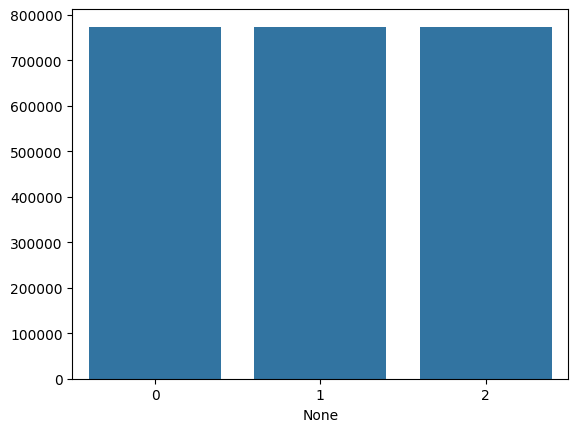

In [6]:
Y = np.array(Y, dtype = int)
val_counts = pd.Series(Y).value_counts()
sns.barplot(
            x = val_counts.index, 
            y = val_counts.values
            )
plt.show()

In [7]:
cls_01 = RandomForestClassifier(
                                n_estimators = 200, 
                                max_depth = 10
                                )

cls_02 = XGBClassifier(
                    n_estimators = 200,
                    max_depth = 10
                    )

cls = VotingClassifier(
                        estimators = [
                                    ('cls_01', cls_01),
                                    ('cls_02', cls_02)
                                    ]
                        )

In [8]:
cls.fit(Xtrain, Ytrain)

VotingClassifier(estimators=[('cls_01',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=200)),
                             ('cls_02',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))])

In [9]:
Ptrain = cls.predict(Xtrain)
Ptest = cls.predict(Xtest)

In [10]:
if not os.path.exists("artifacts/model_stress.pickle"):
    with open("artifacts/model_stress.pickle", "wb") as f:
            pickle.dump(
                        {
                            "cls": cls,
                            "Ptrain": Ptrain,
                            "Ptest": Ptest
                        },
                        f
                        )

### Evaluation

In [11]:
with open("artifacts/model_stress.pickle", "rb") as f:
        data = pickle.load(f)
        Ptrain = data["Ptrain"]
        Ptest = data["Ptest"]
        cls = data["cls"]

c:\Users\kalin\AppData\Local\anaconda3\envs\stress_assesment\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\kalin\AppData\Local\anaconda3\envs\stress_assesment\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\kalin\AppData\Local\anaconda3\envs\stress_assesment\lib\site-packages\sklearn\base.py:376: InconsistentVersionW

In [12]:
cls_report_train = classification_report(
                                        Ytrain, 
                                        Ptrain,
                                        target_names=['Low', 'Medium', 'High']
                                        )
cls_report_test = classification_report(
                                        Ytest, 
                                        Ptest,
                                        target_names=['Low', 'Medium', 'High']
                                        )   

print("============================ Train ============================")
print(cls_report_train)

print("\n============================ Test ============================")
print(cls_report_test)


============================ Train ============================
              precision    recall  f1-score   support

         Low       0.95      0.98      0.97    619087
      Medium       0.97      0.98      0.97    618672
        High       0.98      0.95      0.96    618835

    accuracy                           0.97   1856594
   macro avg       0.97      0.97      0.97   1856594
weighted avg       0.97      0.97      0.97   1856594


============================ Test ============================
              precision    recall  f1-score   support

         Low       0.96      0.98      0.97    154494
      Medium       0.97      0.98      0.97    154909
        High       0.98      0.95      0.96    154746

    accuracy                           0.97    464149
   macro avg       0.97      0.97      0.97    464149
weighted avg       0.97      0.97      0.97    464149



============== Train ==============

============== Test ==============


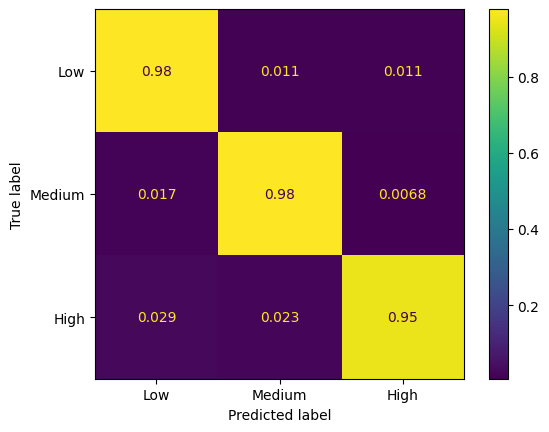

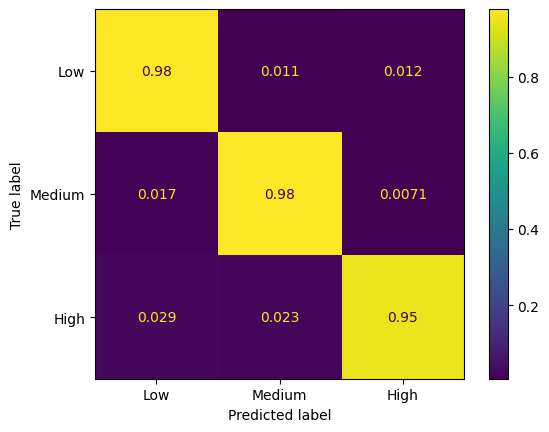

In [13]:
cm_train = confusion_matrix(Ytrain, Ptrain)
cm_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]

cm_test = confusion_matrix(Ytest, Ptest)
cm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

disp_train = ConfusionMatrixDisplay(
                                confusion_matrix = cm_train,
                                display_labels = ['Low', 'Medium', 'High']
                                )           
disp_test = ConfusionMatrixDisplay(
                                confusion_matrix = cm_test,
                                display_labels = ['Low', 'Medium', 'High']
                                )   

print("============== Train ==============")            
disp_train.plot()

print("\n============== Test ==============")
disp_test.plot()

### Inference

In [1]:
import pickle
import numpy as np
import pandas as pd 

In [2]:
with open("artifacts/model_stress.pickle", "rb") as f:
    data = pickle.load(f)
    Ptrain = data["Ptrain"]
    Ptest = data["Ptest"]
    cls = data["cls"]

c:\Users\kalin\AppData\Local\anaconda3\envs\stress_assesment\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\kalin\AppData\Local\anaconda3\envs\stress_assesment\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\kalin\AppData\Local\anaconda3\envs\stress_assesment\lib\site-packages\sklearn\base.py:376: InconsistentVersionW

In [3]:
sample_data = {
    "id": "kalindu",
    "data": [
        {
            "HR": 48.76,
            "TEMP": 30.06,
            "datetime": "2024-11-23 09:31:00"
        },
        {
            "HR": 48.76,
            "TEMP": 30.06,
            "datetime": "2024-11-23 09:31:01"
        },
        {
            "HR": 69.28,
            "TEMP": 30.06,
            "datetime": "2024-11-23 09:31:02"
        },
        {
            "HR": 69.28,
            "TEMP": 30.06,
            "datetime": "2024-11-23 09:31:03"
        },
        {
            "HR": 46.77,
            "TEMP": 30.06,
            "datetime": "2024-11-23 09:31:04"
        },
        {
            "HR": 52.35,
            "TEMP": 30.56,
            "datetime": "2024-11-23 09:31:05"
        },
        {
            "HR": 54.7,
            "TEMP": 30.56,
            "datetime": "2024-11-23 09:31:06"
        },
        {
            "HR": 54.7,
            "TEMP": 31.38,
            "datetime": "2024-11-23 09:31:07"
        },
        {
            "HR": 46.79,
            "TEMP": 31.75,
            "datetime": "2024-11-23 09:31:08"
        },
        {
            "HR": 96.43,
            "TEMP": 31.75,
            "datetime": "2024-11-23 09:31:09"
        },
        {
            "HR": 96.43,
            "TEMP": 31.94,
            "datetime": "2024-11-23 09:31:10"
        },
        {
            "HR": 96.43,
            "TEMP": 32.06,
            "datetime": "2024-11-23 09:31:11"
        },
        {
            "HR": 34.7,
            "TEMP": 32.06,
            "datetime": "2024-11-23 09:31:12"
        },
        {
            "HR": 34.7,
            "TEMP": 32.06,
            "datetime": "2024-11-23 09:31:13"
        },
        {
            "HR": 41.53,
            "TEMP": 32.13,
            "datetime": "2024-11-23 09:31:14"
        },
        {
            "HR": 77.87,
            "TEMP": 32.25,
            "datetime": "2024-11-23 09:31:15"
        },
        {
            "HR": 47.83,
            "TEMP": 32.25,
            "datetime": "2024-11-23 09:31:16"
        },
        {
            "HR": 63.92,
            "TEMP": 32.25,
            "datetime": "2024-11-23 09:31:17"
        },
        {
            "HR": 63.92,
            "TEMP": 32.31,
            "datetime": "2024-11-23 09:31:18"
        },
        {
            "HR": 75.26,
            "TEMP": 32.31,
            "datetime": "2024-11-23 09:31:19"
        },
        {
            "HR": 83.98,
            "TEMP": 32.31,
            "datetime": "2024-11-23 09:31:20"
        },
        {
            "HR": 83.98,
            "TEMP": 32.38,
            "datetime": "2024-11-23 09:31:21"
        },
        {
            "HR": 59.42,
            "TEMP": 32.38,
            "datetime": "2024-11-23 09:31:22"
        },
        {
            "HR": 59.42,
            "TEMP": 32.38,
            "datetime": "2024-11-23 09:31:23"
        },
        {
            "HR": 59.42,
            "TEMP": 32.44,
            "datetime": "2024-11-23 09:31:24"
        },
        {
            "HR": 45.47,
            "TEMP": 32.38,
            "datetime": "2024-11-23 09:31:25"
        },
        {
            "HR": 69.83,
            "TEMP": 32.38,
            "datetime": "2024-11-23 09:31:26"
        },
        {
            "HR": 49.51,
            "TEMP": 32.38,
            "datetime": "2024-11-23 09:31:27"
        },
        {
            "HR": 49.51,
            "TEMP": 32.38,
            "datetime": "2024-11-23 09:31:28"
        },
        {
            "HR": 48.02,
            "TEMP": 32.38,
            "datetime": "2024-11-23 09:31:29"
        },
        {
            "HR": 48.02,
            "TEMP": 32.44,
            "datetime": "2024-11-23 09:31:30"
        },
        {
            "HR": 63.86,
            "TEMP": 32.44,
            "datetime": "2024-11-23 09:31:31"
        },
        {
            "HR": 43.86,
            "TEMP": 32.44,
            "datetime": "2024-11-23 09:31:32"
        },
        {
            "HR": 43.86,
            "TEMP": 32.44,
            "datetime": "2024-11-23 09:31:33"
        },
        {
            "HR": 60.06,
            "TEMP": 32.44,
            "datetime": "2024-11-23 09:31:34"
        },
        {
            "HR": 70.97,
            "TEMP": 32.44,
            "datetime": "2024-11-23 09:31:35"
        },
        {
            "HR": 51.82,
            "TEMP": 32.44,
            "datetime": "2024-11-23 09:31:36"
        },
        {
            "HR": 95.44,
            "TEMP": 32.44,
            "datetime": "2024-11-23 09:31:37"
        },
        {
            "HR": 95.44,
            "TEMP": 32.44,
            "datetime": "2024-11-23 09:31:38"
        },
        {
            "HR": 49.11,
            "TEMP": 32.44,
            "datetime": "2024-11-23 09:31:39"
        },
        {
            "HR": 62.21,
            "TEMP": 32.44,
            "datetime": "2024-11-23 09:31:40"
        },
        {
            "HR": 50.03,
            "TEMP": 32.44,
            "datetime": "2024-11-23 09:31:41"
        },
        {
            "HR": 123.88,
            "TEMP": 32.44,
            "datetime": "2024-11-23 09:31:42"
        },
        {
            "HR": 123.88,
            "TEMP": 32.13,
            "datetime": "2024-11-23 09:31:43"
        },
        {
            "HR": 78.93,
            "TEMP": 31.81,
            "datetime": "2024-11-23 09:31:44"
        }
    ]
}

In [4]:
def inference_stress(data):
    id_ = data["id"]
    del data["id"]

    data = pd.DataFrame(data["data"])

    TEMP = data["TEMP"].values
    if sum((TEMP < 26) | (TEMP > 38)):
        return {
                "id": id_,
                "stress": "The temperature should be between 26 and 38"
                }
    
    X = data.drop(columns = ["datetime"]).values
    P = cls.predict(X)
    
    avg_stress = np.sum(P) / (len(P)*2)
    if avg_stress < 0.25:
        status = "Resilient"
    elif avg_stress < 0.75:
        status = "Adaptive"
    else:
        status = "Overwhelmed"

    avg_stress = avg_stress * 100
    return {
            "id": id_,
            "stress": status,
            "average stress": f"{avg_stress:.2f}%"
            }

In [5]:
inference_stress(sample_data)

{'id': 'kalindu', 'stress': 'Adaptive', 'average stress': '73.33%'}